# GCN for Cox Model
In this notebook, we build a graph, and execute a Cox Model with a GCN.

In [138]:
import pandas as pd
import numpy as np
import torch
from models.GCNCoxModel import GCNCoxModel
from models.BuildGraph import BuildGraph
from manage.GCNCoxTrainTestManager import GCNCoxTrainTestManager

## 1. Build the graph
Here, we split the patients by tumour type.

### Reading the dataset

In [139]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df["Clinical benefit"] = np.where(df["Clinical benefit"]=="DCB",1,0)
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,0,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,0,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,0,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,0,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,0,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,1,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,0,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,0,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,0,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


In [140]:
buildgraph = BuildGraph(df)

### Compute the adjacency matrix

In [141]:
buildgraph.compute_adjacency_matrix("Tumour type")
display(buildgraph.A)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Build the graph

In [142]:
features_label = ["CD8+ T cell score","Exome mut per mb"]
y_label = "Clinical benefit"

buildgraph.create_graph(features_label, y_label)

### Show the graph

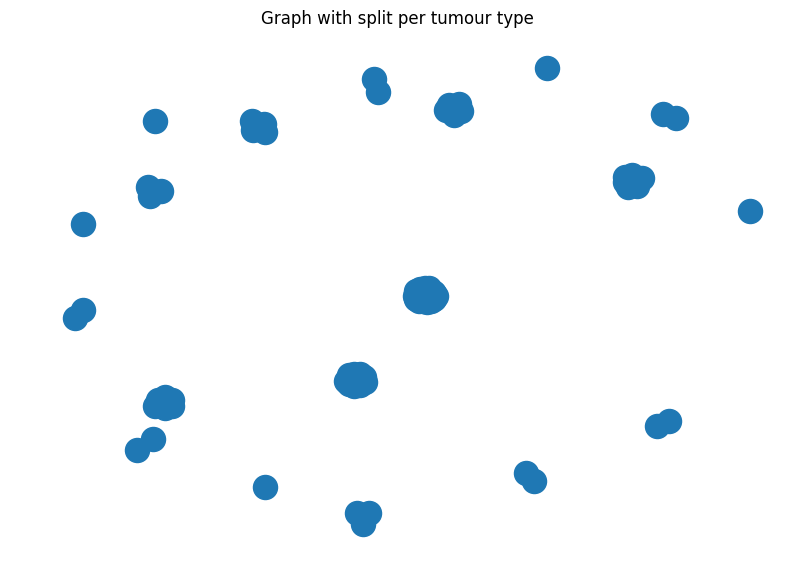

In [143]:
buildgraph.show_graph("Graph with split per tumour type","tumour-type.png")

## 2. Building the GCN Cox Model

### Formatting data

In [144]:
from torch_geometric.utils.convert import from_networkx

pyg_graph = from_networkx(buildgraph.G)
status = torch.from_numpy(df["Alive_0"].to_numpy()).float().unsqueeze(1)
time = torch.from_numpy(df["Overall survival (days)"].to_numpy()).float().unsqueeze(1)

### Instanciate the model

In [145]:
model = GCNCoxModel(num_features=2)
model

GCNCoxModel(
  (conv): GCNConv(2, 2)
  (regression): Linear(in_features=2, out_features=1, bias=True)
)

## 3. Training the GCN

In [146]:
trainer = GCNCoxTrainTestManager(model, pyg_graph, status, time)

In [147]:
trainer.train(100)

Epoch 1 of 100


Epoch 11 of 100
Epoch 21 of 100
Epoch 31 of 100
Epoch 41 of 100
Epoch 51 of 100
Epoch 61 of 100
Epoch 71 of 100
Epoch 81 of 100
Epoch 91 of 100
End of training.


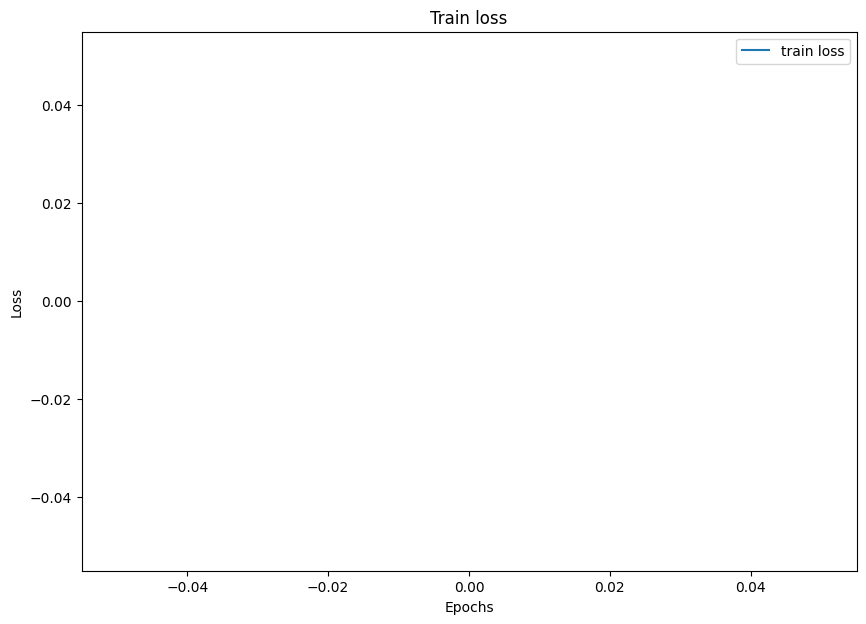

In [148]:
# Plot loss function
trainer.plot_loss()

## 4. Estimating survival function and plot survival curves

In [149]:
g = model(pyg_graph.x, pyg_graph.edge_index)

In [150]:
import numpy as np
time_max = torch.max(time)

T = torch.Tensor(np.linspace(0, time_max, num=100)).float()
T

tensor([   0.0000,   12.9596,   25.9192,   38.8788,   51.8384,   64.7980,
          77.7576,   90.7172,  103.6768,  116.6364,  129.5960,  142.5556,
         155.5152,  168.4747,  181.4343,  194.3939,  207.3535,  220.3131,
         233.2727,  246.2323,  259.1919,  272.1515,  285.1111,  298.0707,
         311.0303,  323.9899,  336.9495,  349.9091,  362.8687,  375.8283,
         388.7879,  401.7475,  414.7071,  427.6667,  440.6263,  453.5858,
         466.5454,  479.5050,  492.4647,  505.4243,  518.3839,  531.3434,
         544.3030,  557.2626,  570.2222,  583.1818,  596.1414,  609.1010,
         622.0606,  635.0202,  647.9798,  660.9394,  673.8990,  686.8586,
         699.8182,  712.7778,  725.7374,  738.6970,  751.6566,  764.6161,
         777.5757,  790.5353,  803.4949,  816.4545,  829.4141,  842.3737,
         855.3333,  868.2929,  881.2525,  894.2121,  907.1717,  920.1313,
         933.0909,  946.0505,  959.0101,  971.9697,  984.9293,  997.8889,
        1010.8485, 1023.8081, 1036.767

### Cumulative hazard : H(t|x)

In [151]:
def H0(g, T, status, time):
    """ 
    Breslow estimator.
    """
    h0 = torch.zeros((g.shape[0],T.shape[0]))
    for k in range(T.shape[0]):
        to_sum_k = torch.where(time<=T[k])
        g_k, status_k, time_k = g[to_sum_k], status[to_sum_k], time[to_sum_k]
        for i in range(g_k.shape[0]):
            status_ki, T_ki = status_k[i], time_k[i]
            to_sum = torch.where((status_ki == 1) & (time_k>=T_ki))[0]
            h0[i][k] += status_ki/torch.sum(torch.exp(g_k[to_sum]))
    return h0

def H(g, T, status, time):
    """ 
    Cumulative HR
    """
    h0 = H0(g, T, status, time)
    return h0 * torch.exp(g)

In [152]:
h = H(g, time, status, time)
h

tensor([[1.0000, 0.0625, 0.1667,  ..., 0.1250, 0.0370, 0.0196],
        [0.0189, 0.5000, 1.0000,  ..., 0.3333, 0.0526, 0.0417],
        [0.5000, 0.0909, 0.0172,  ..., 0.0167, 0.1250, 0.0233],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

### Survival function : S(t|x)

In [153]:
def S(H):
    return torch.exp(-H)

In [154]:
s = S(h)
s

tensor([[0.3679, 0.9394, 0.8465,  ..., 0.8825, 0.9636, 0.9806],
        [0.9813, 0.6065, 0.3679,  ..., 0.7165, 0.9487, 0.9592],
        [0.6065, 0.9131, 0.9829,  ..., 0.9835, 0.8825, 0.9770],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       grad_fn=<ExpBackward0>)

### Plot survival curve

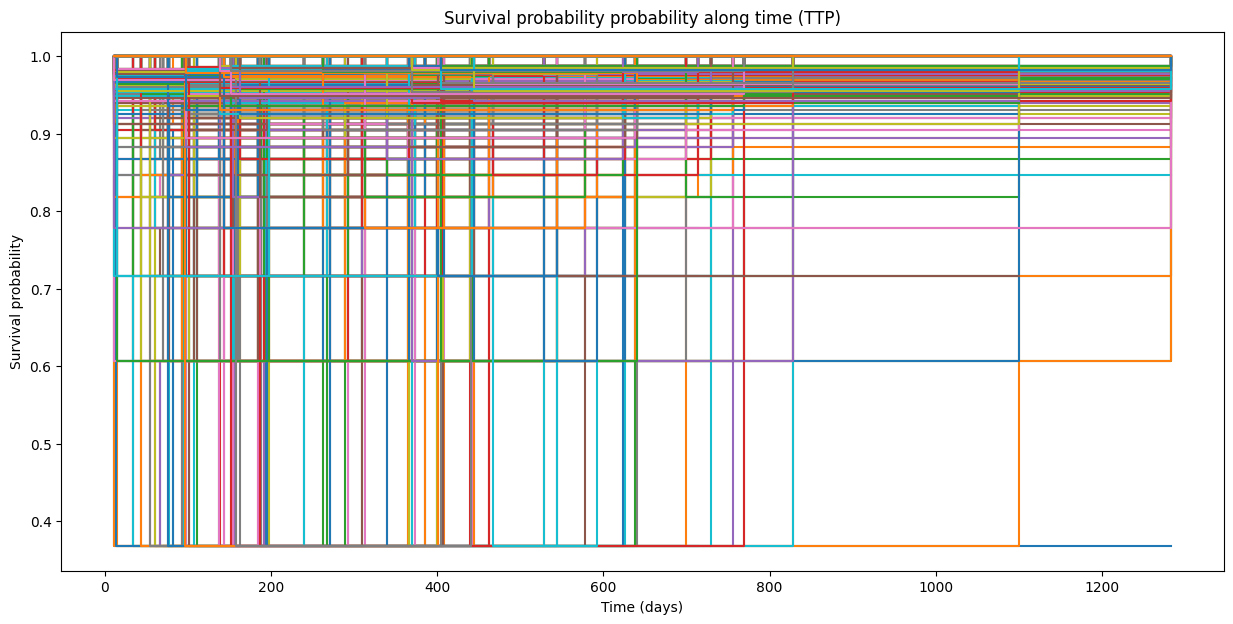

In [157]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
for i in range(s.shape[0]):
    s_patient = s[i].detach().numpy()
    ax.step(time, s_patient, where='post')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival probability')
ax.set_title('Survival probability probability along time (OS)')

plt.savefig('test-curve.png')